Instructions for updating:
Use `tf.linalg.matmul` instead


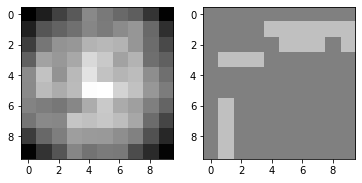

55 0.28596032 0.011237783
False


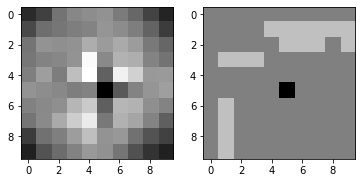

44 0.3262459 0.011677102
False


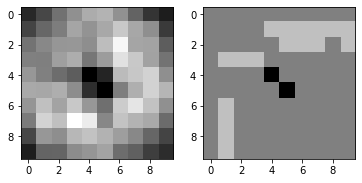

73 0.30946603 0.011457983
False


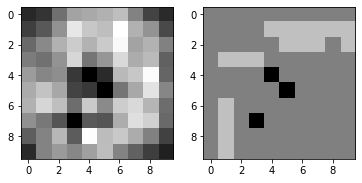

16 0.3085202 0.011433939
True


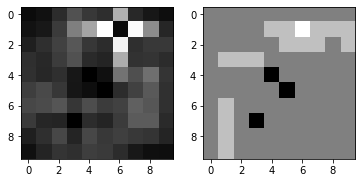

15 0.67888445 0.016611125
True


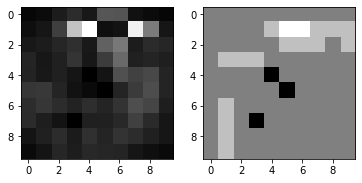

14 0.8201297 0.019478902
True


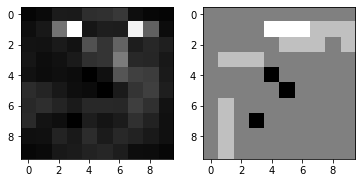

13 0.85311973 0.020546999
False


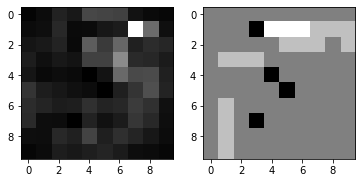

17 0.83200186 0.020259537
True


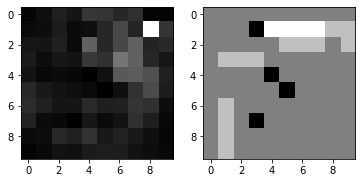

18 0.7887005 0.019710677
True


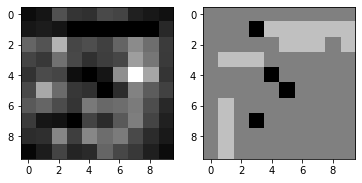

47 0.39552355 0.013355024
False


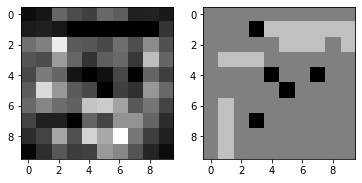

86 0.31095865 0.012296722
False


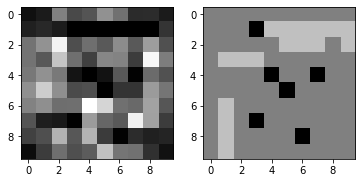

64 0.28490818 0.011981018
False


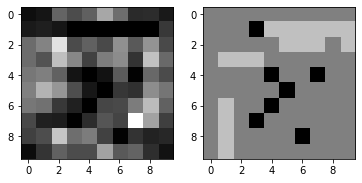

77 0.32399896 0.012463589
False


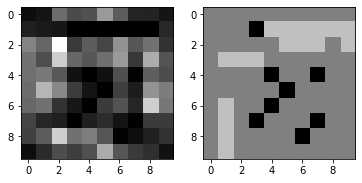

22 0.370337 0.013017665
False


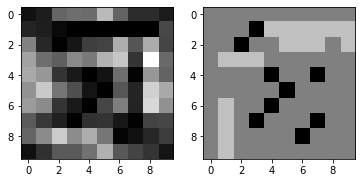

38 0.32683057 0.012445293
False


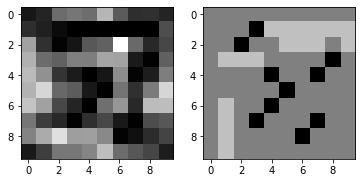

26 0.31081885 0.012258679
True


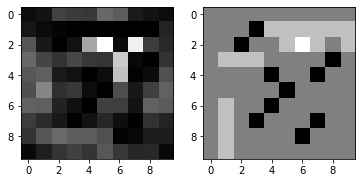

25 0.4692018 0.014485108
True


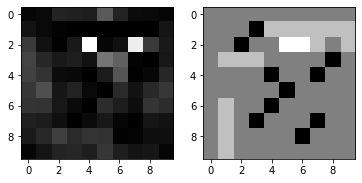

24 0.66155744 0.017751653
False


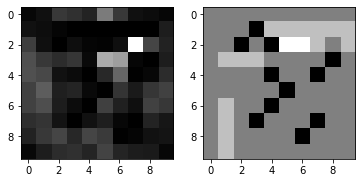

27 0.5533517 0.015982406
True


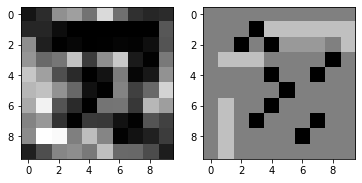

81 0.26882175 0.01193023
True


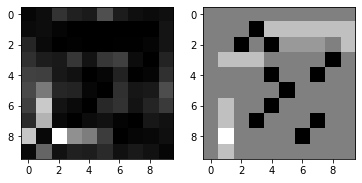

82 0.67239755 0.017764157
False


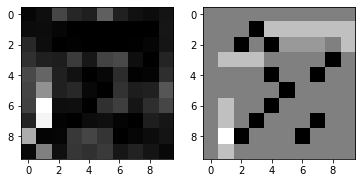

61 0.6205828 0.016987793
True


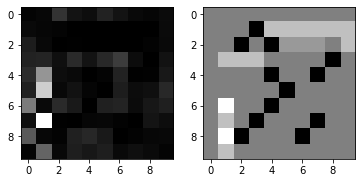

71 0.83326334 0.021130184
True


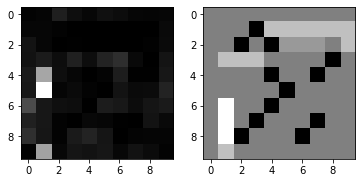

51 0.81074023 0.021064388
False


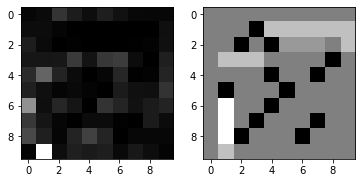

91 0.56998324 0.016753927
True


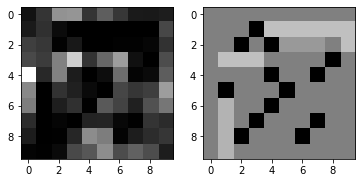

40 0.2775467 0.01247444
False


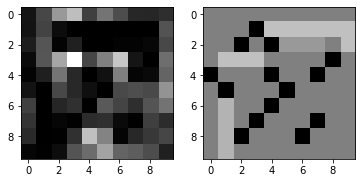

33 0.24556327 0.01212422
True


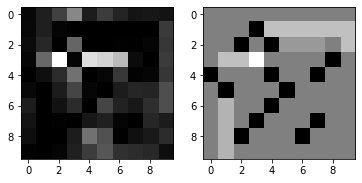

32 0.3705395 0.01371633
True


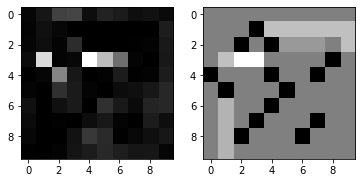

34 0.49920207 0.015679266
False


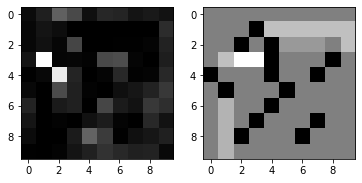

31 0.38984796 0.014154214
True


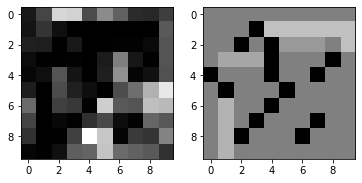

84 0.16548797 0.011357962
False


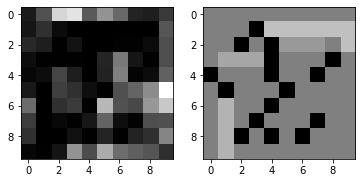

59 0.18762347 0.01160591
False


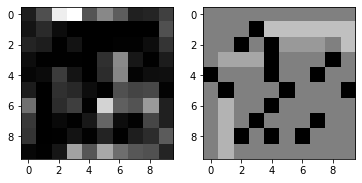

3 0.20913061 0.011873111
False


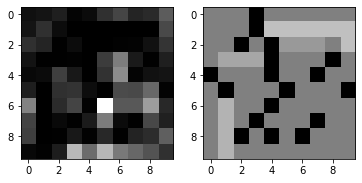

65 0.2094338 0.011909681
False


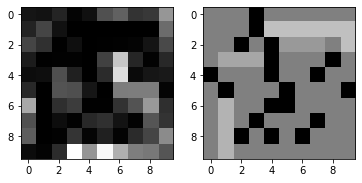

93 0.16261733 0.011383736
False


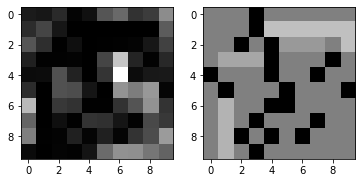

46 0.16549161 0.011436286
False


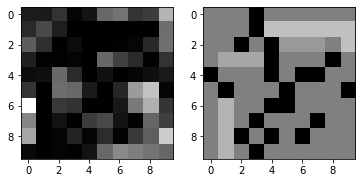

60 0.15468499 0.011323803
False


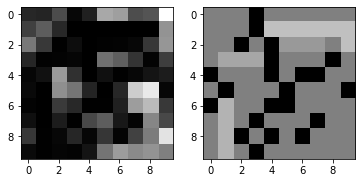

9 0.13495746 0.011112829
False


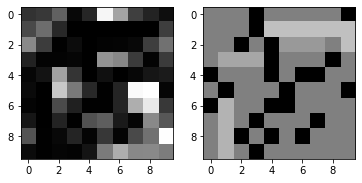

58 0.13080111 0.01106597
False


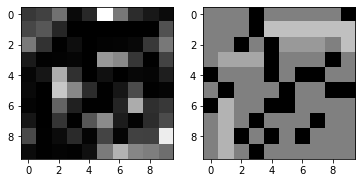

5 0.14586437 0.01124739
False


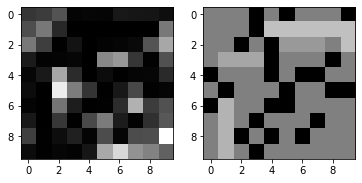

89 0.14470524 0.011238875
False


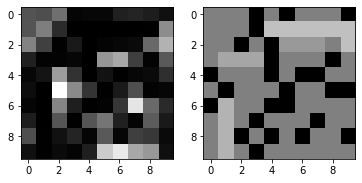

52 0.12957332 0.011090504
False


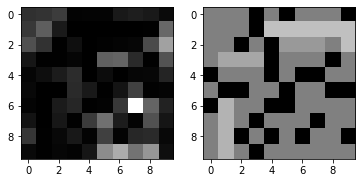

67 0.19270852 0.011811703
False


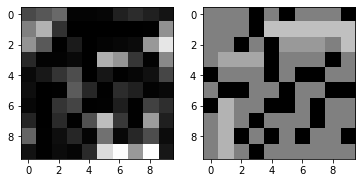

98 0.122112155 0.011028618
False


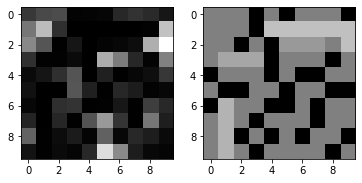

29 0.13558102 0.011192382
True


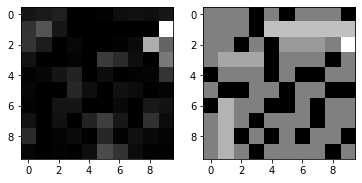

19 0.27747297 0.012890675
True
[46, 0]
Average Score: 23.0
choice 1:0.3695652173913043  choice 0:0.6304347826086957


In [1]:
import gym
import gym_battleship1

import tensorflow as tf
import h5py
import numpy as np

import tensorflow.keras.losses
tensorflow.keras.losses.custom_loss = tf.nn.sigmoid_cross_entropy_with_logits

tf.keras.backend.set_image_data_format('channels_last')
from customs import customAccuracy, buildModel

from matplotlib import pyplot

env = gym.make('battleship1-v1')
env.reset()

# model.summary()
model = buildModel()
model.load_weights('saved_model/leviathan.h5', skip_mismatch=True, by_name=True) #unec?
weights = h5py.File('saved_model/leviathan.h5', 'r')
if tensorflow.keras.backend.image_data_format() == "channels_last":
	LCWeights = weights['model_weights']['locally_connected2d']['locally_connected2d']
	unrolled = LCWeights['kernel:0'][()]
	LCKern = np.array(unrolled)
	LCKern = np.transpose(LCKern, [1,2,0,3,4,5])
	LCKern = np.transpose(LCKern, [0,1,2,4,5,3])
	LCWeights = [LCKern, LCWeights['bias:0'][()]]
	model.layers[-2].set_weights(LCWeights)

def displayKernel(lay, ch=None):
	if model.layers[lay].use_bias:
		filters, biases = model.layers[lay].get_weights()
	else:
		filters = model.layers[lay].get_weights()[0]
	if ch is None:
		chRange = range(min([2,int(filters.shape[2])]))
	else:
		chRange = range(ch[0], ch[1])
	pyplot.close()
	# retrieve weights from the second hidden layer
	# normalize filter values to 0-1 so we can visualize them
	f_min, f_max = filters.min(), filters.max()
	filters = (filters - f_min) / (f_max - f_min)
	# plot first few filters
	n_filters, ix = 7, 1
	for i in range(n_filters):
		# get the filter
		f = filters[:, :, :, i]
		# plot each channel separately
		for j in chRange:
			# specify subplot and turn of axis
			ax = pyplot.subplot(n_filters, len(chRange), ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(f[:, :, j], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

# displayKernel(-2)
def scaler(x):
	if x.value[1] == "!M!":
		return -2
	elif '(' in x.value[1]:
		return 2
	return x.value[0]

vfunc = np.vectorize(scaler)
def heatMap(y_preds, state=None):
# 	pyplot.close()
	y_preds = np.reshape(y_preds, (10,10))
	ax = pyplot.subplot(1,2,1)
	pyplot.imshow(y_preds, cmap='gray')
	if state is not None:
		bx = pyplot.subplot(1,2,2)
		x = np.array(state)
		x = vfunc(x)
		pyplot.imshow(x, cmap='gray', vmin=-2, vmax=2)
	pyplot.show()

scores = []
choices = []
for each_game in range(1):
	score = 0
	prev_obs, _ = env.reset()
	prev_obs = [[[x.value[0] for x in y] for y in c] for c in prev_obs] # redo timeit with numpy
	prev_obs = tf.convert_to_tensor([prev_obs])
	if tensorflow.keras.backend.image_data_format() == "channels_last":
		prev_obs = tf.transpose(prev_obs, [0,2,3,1])
	prev_action = -1
	for step_index in range(500):
		# env.render()

		# if len(prev_obs)==0:
		# 	action = 50
		# elif step_index < 50:
		# 	action = step_index

		logits = model(tf.cast(prev_obs, tf.float32), training=False)[0]
		heatMap(logits.numpy(), env.state)
# 		raise
		action = tf.argmax(logits,-1).numpy()
		print(action, logits[action].numpy(), tf.nn.softmax(logits)[action].numpy())
		
		# print(action, prev_obs)

		new_observation, reward, done, _ = env.step(action)
		print(reward)
		choices.append(1 if reward else 0)

		prev_obs = new_observation
		prev_obs = [[[x.value[0] for x in y] for y in c] for c in prev_obs] # redo timeit with numpy
		prev_obs = tf.convert_to_tensor([prev_obs])
		if tensorflow.keras.backend.image_data_format() == "channels_last":
			prev_obs = tf.transpose(prev_obs, [0,2,3,1])

		prev_action = action
		if done:
			scores.append(env.counter)
			break
	scores.append(score)

print(scores)
print('Average Score:', sum(scores)/len(scores))
print('choice 1:{}  choice 0:{}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))

In [2]:
model.weights[4]

<tf.Variable 'conv2d_2/kernel:0' shape=(5, 5, 2, 16) dtype=float32, numpy=
array([[[[ 6.29526526e-02,  1.56942885e-02, -9.08915419e-03,
           3.43391076e-02, -3.97580713e-02,  5.90131693e-02,
           4.11658995e-02, -9.67430323e-03, -1.00579606e-02,
           4.52690665e-03, -4.50882763e-02,  5.32563031e-02,
           3.02864294e-02, -2.08975021e-02,  5.87038808e-02,
          -4.38685790e-02],
         [-5.54104783e-02, -8.45263675e-02,  1.11440793e-02,
          -8.61263275e-02,  5.27534932e-02, -9.36708972e-02,
           1.00877322e-02,  6.86466172e-02,  6.42318428e-02,
           5.24854660e-02,  7.53486380e-02, -1.00417659e-01,
          -1.27168804e-01,  3.40503007e-02, -1.26809970e-01,
          -1.79316606e-02]],

        [[ 2.39024479e-02,  4.08125632e-02,  9.64371338e-02,
           9.94226784e-02,  4.14055213e-02,  1.49560168e-01,
           2.93498300e-02,  5.02949543e-02, -5.76206716e-03,
          -5.13349101e-03,  5.48249520e-02,  3.08268890e-02,
           4.

for c in range(33):
    print(c)
    for x in range(10):
        for y in range(10):
            for x1 in range(10):
                for y1 in range(10):
                    assert model.weights[-2][y][x][c][y1][x1][0] == unrolled[c][y][x][0][y1][x1]
print("all done")

for c in range(33):
    for x in range(10):
        for y in range(10):
            for x1 in range(10):
                for y1 in range(10):
                    assert LCKern[y][x][c][y1][x1][0] == unrolled[c][y][x][0][y1][x1]
print("all done")